In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statsmodels
sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import pmdarima as pm


Wczytanie i podział danych

In [18]:
data = pd.read_csv(r"/Users/wojtek/Desktop/KASC/raport/GlobalTemperatures2.csv")
data['dt'] = pd.to_datetime(data['dt']).dt.to_period('M').astype(str)
month = data['dt']
time = np.arange(0,len(month),1)
temperature = data['LandAverageTemperature'] 

Wizualizacja

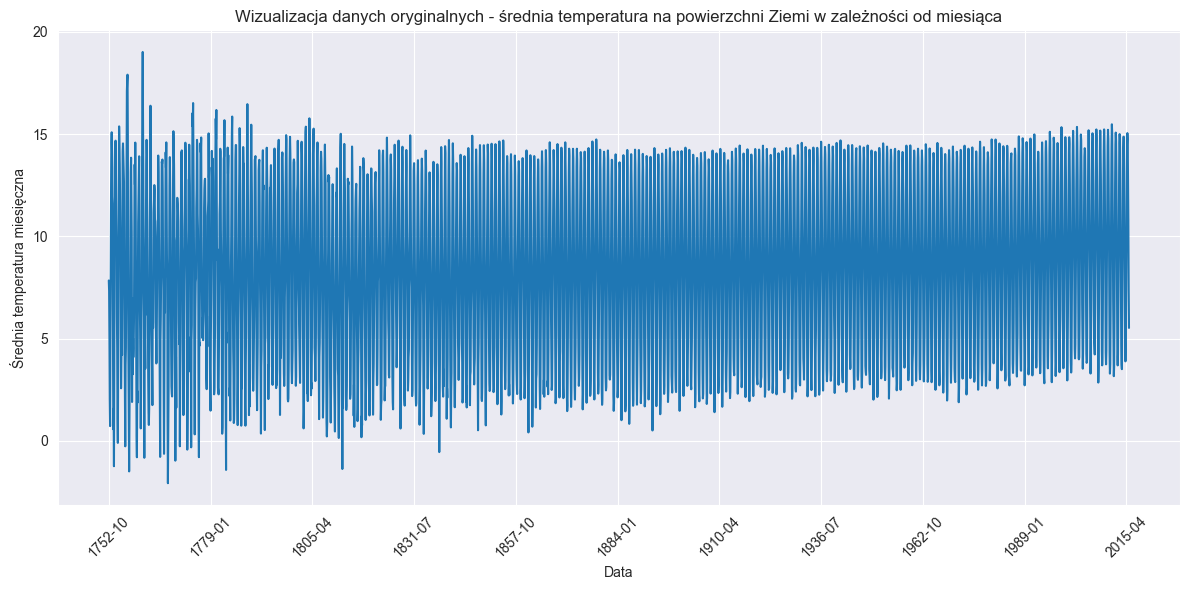

In [19]:
num_labels = 10  # Liczba etykiet, które mają być widoczne
indices = list(range(0, len(month), len(month) // num_labels))  # Indeksy równomiernie rozmieszczonych dat
selected_months = [month[i] for i in indices]  # Wybrane daty

plt.figure(figsize=(12, 6))
plt.plot(month, temperature)
plt.xticks(ticks=indices, labels=selected_months, rotation=45)  # Ustawienie etykiet osi X
plt.xlabel('Data')
plt.ylabel('Średnia temperatura miesięczna')
plt.title('Wizualizacja danych oryginalnych - średnia temperatura na powierzchni Ziemi w zależności od miesiąca')
plt.tight_layout()  # Zapewnienie lepszej estetyki wykresu
plt.show()


Sprawdzenie, czy są puste rekordy

In [20]:
data_info = data.info()
data_head = data.head()
data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3159 entries, 0 to 3158
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3159 non-null   object 
 1   LandAverageTemperature                     3159 non-null   float64
 2   LandAverageTemperatureUncertainty          3159 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 222.2+ KB


(None,
         dt  LandAverageTemperature  LandAverageTemperatureUncertainty  \
 0  1752-10                   7.839                              2.754   
 1  1752-11                   7.335                              2.747   
 2  1752-12                   5.086                              2.982   
 3  1753-01                   2.039                              3.478   
 4  1753-02                   0.715                              6.341   
 
    LandMaxTemperature  LandMaxTemperatureUncertainty  LandMinTemperature  \
 0                 NaN                            NaN                 NaN   
 1                 NaN                            NaN                 NaN   
 2                 NaN                            NaN                 NaN   
 3                 NaN                            NaN                 NaN   
 4                 NaN                            NaN                 NaN   
 
    LandMinTemperatureUncertainty  LandAndOceanAverageTemperature  \
 0            

Obserwacje odstające, statystyki opisowe dla zmiennej rainfalls

In [21]:
temperature_stats = data['LandAverageTemperature'].describe()
time_stats = data["dt"].describe()

Q1 = data['LandAverageTemperature'].quantile(0.25)
Q3 = data['LandAverageTemperature'].quantile(0.75)
IQR = Q3 - Q1
outlier_thresholds = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
outliers = data[(data['LandAverageTemperature'] < outlier_thresholds[0]) | 
                (data['LandAverageTemperature'] > outlier_thresholds[1])]

temperature_stats, time_stats, outliers

(count    3159.000000
 mean        8.377803
 std         4.378687
 min        -2.080000
 25%         4.318500
 50%         8.618000
 75%        12.548500
 max        19.021000
 Name: LandAverageTemperature, dtype: float64,
 count        3159
 unique       3159
 top       1752-10
 freq            1
 Name: dt, dtype: object,
 Empty DataFrame
 Columns: [dt, LandAverageTemperature, LandAverageTemperatureUncertainty, LandMaxTemperature, LandMaxTemperatureUncertainty, LandMinTemperature, LandMinTemperatureUncertainty, LandAndOceanAverageTemperature, LandAndOceanAverageTemperatureUncertainty]
 Index: [])

Sprawdzenie ciągłości miesięcy 

In [22]:
for i in range(1, len(month)):
    m_present = int(month[i][-2:])
    y_present = int(month[i][:4])
    m_previous = int(month[i-1][-2:])
    y_previous = int(month[i-1][:4])
    if m_present != m_previous + 1:
        if m_present == m_previous - 11:
            if y_present != y_previous + 1:
                print(f"Występuje brak ciągłości miesięcy między: {month[i-1]} a {month[i]}")
                break
        else:
            print(f"Występuje brak ciągłości miesięcy między: {month[i-1]} a {month[i]}")
            break
    if i == len(month)-1:
        print("W miesiącach nie brakuje danych, ciąłość jest zachowana")


W miesiącach nie brakuje danych, ciąłość jest zachowana


Przygotowanie zbioru testowego i treningowego

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
train, test = train_test_split(temperature, test_size=0.2, shuffle=False)

ACF i PACF

In [25]:
h_max = 40

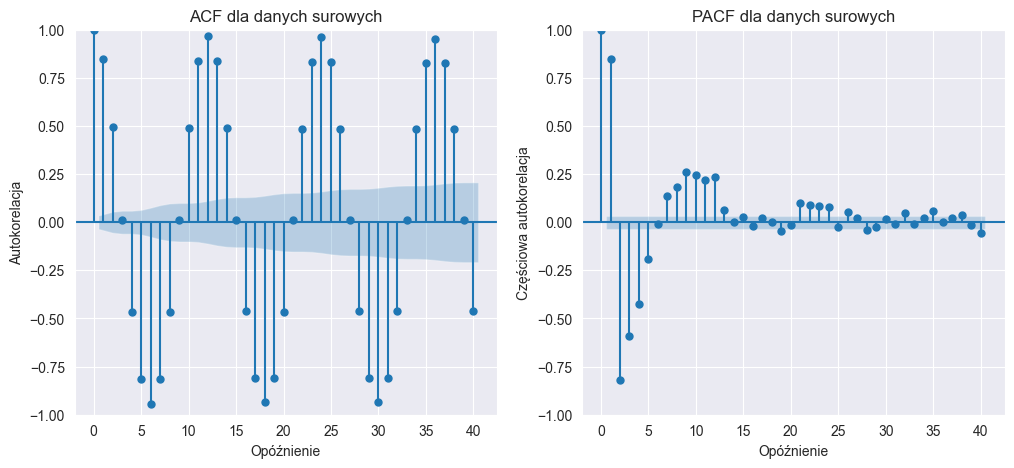

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plot_acf(temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych surowych')

plt.subplot(122)
plot_pacf(temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla danych surowych')

plt.show()

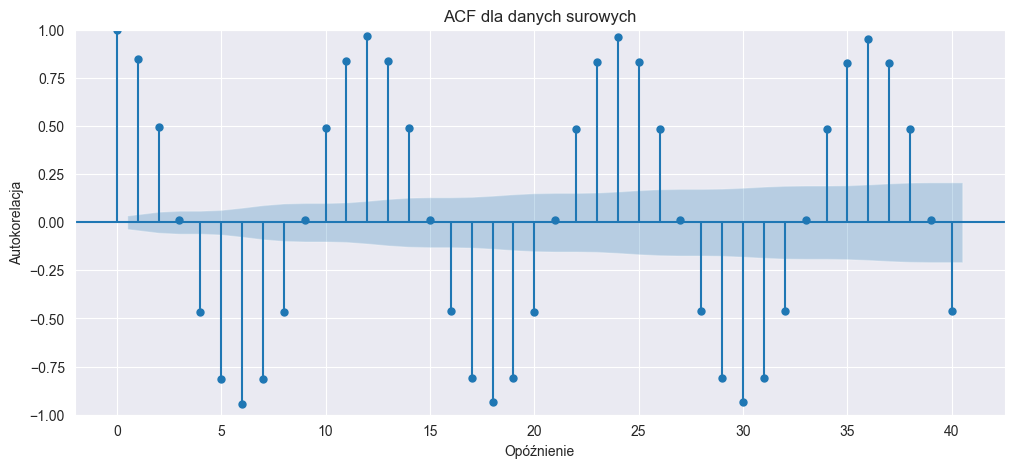

In [27]:
plt.figure(figsize=(12, 5))
plot_acf(temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych surowych')
plt.show()


Okres wynosi około 12

Test stacjonarności - Augmented Dickey-Fuller Test

In [28]:
def adfuller_test(series, sig = 0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [29]:
adfuller_test(temperature)

Statystyka testowa = -3.653, p-Value = 0.005 => Stationary. 


Dekompozycja

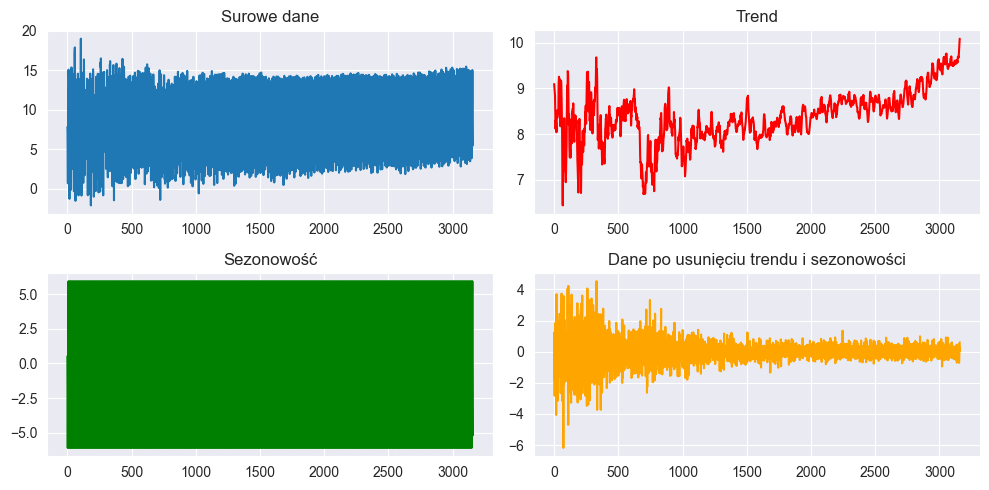

In [30]:
decomposition = seasonal_decompose(temperature, model='additive', period = 12, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(temperature, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

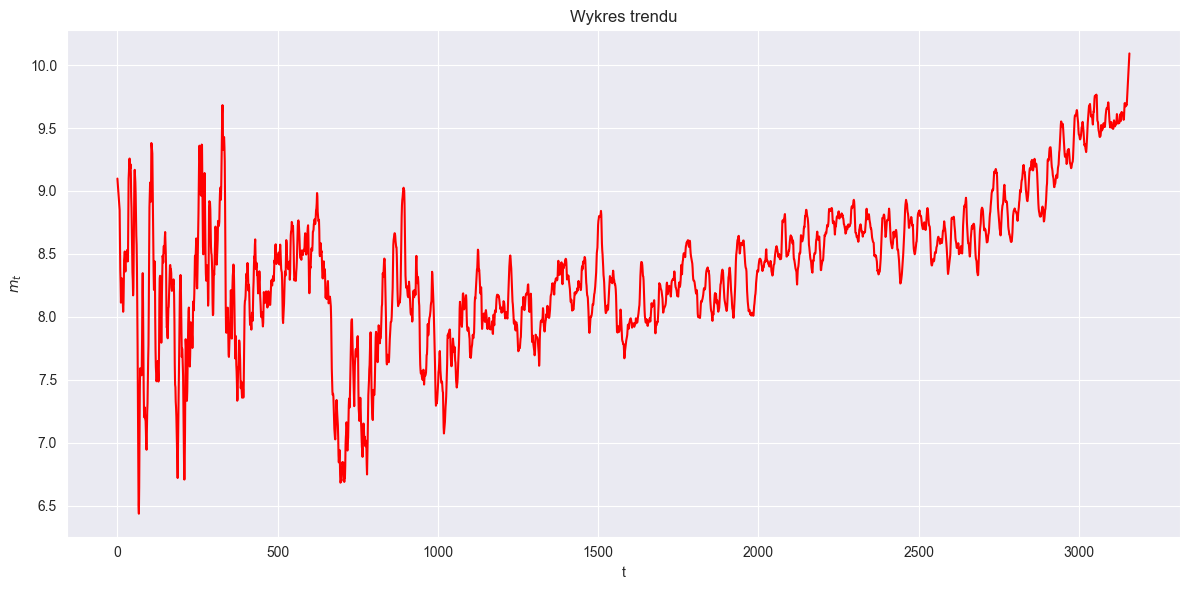

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(trend, label='Trend', color='red')
plt.xlabel("t")
plt.ylabel("$m_t$")
plt.title('Wykres trendu')
plt.tight_layout()
plt.show()

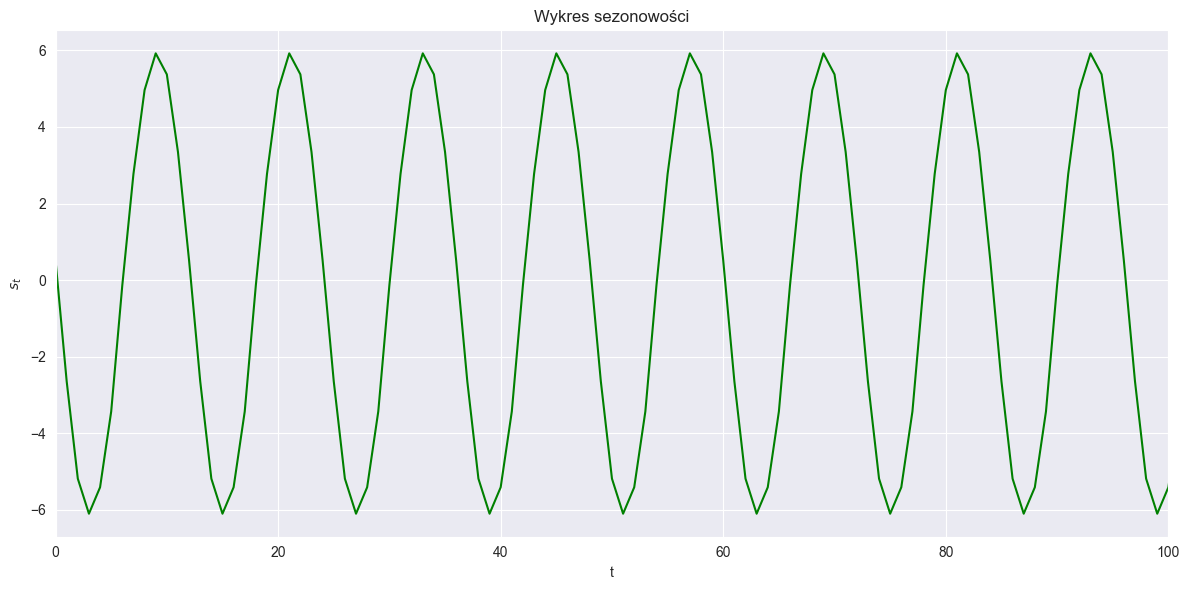

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(seasonal, label='Sezonowość', color='green')
plt.xlabel("t")
plt.xlim((0,100))
plt.ylabel("$s_t$")
plt.title('Wykres sezonowości')
plt.tight_layout()
plt.show()

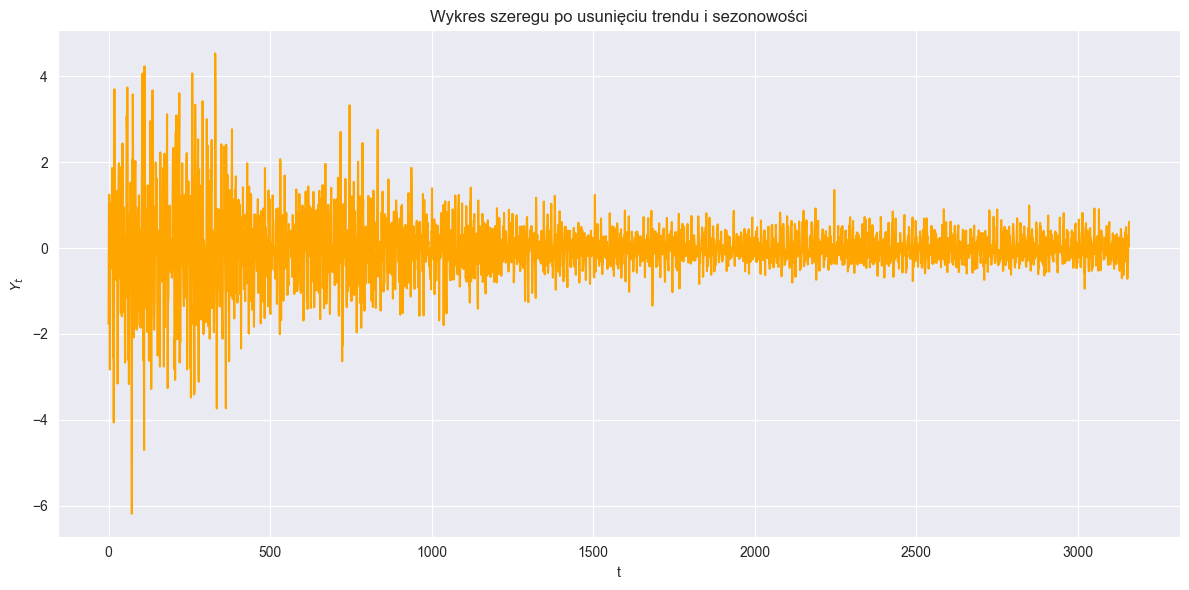

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(residual, label='Szum losowy', color='orange')
plt.xlabel("t")
plt.ylabel("$Y_t$")
plt.title('Wykres szeregu po usunięciu trendu i sezonowości')
plt.tight_layout()
plt.show()

In [34]:
nowa_temperature = list(temperature[1767:])

(1100.0, 1200.0)

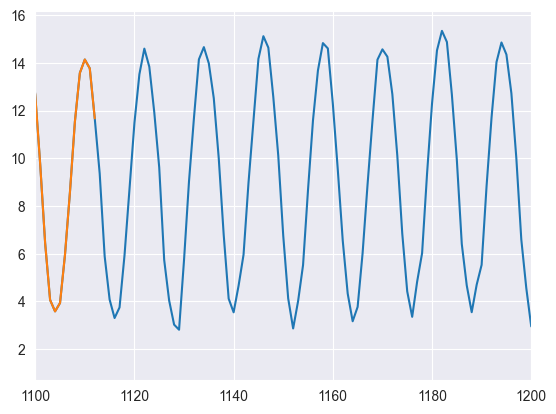

In [103]:
plt.plot(nowa_temperature)
plt.plot(nowa_temperature[:1113])

plt.xlim(1100,1200)

In [35]:
print(len(temperature),len(nowa_temperature),len(temperature)-len(nowa_temperature))

3159 1392 1767


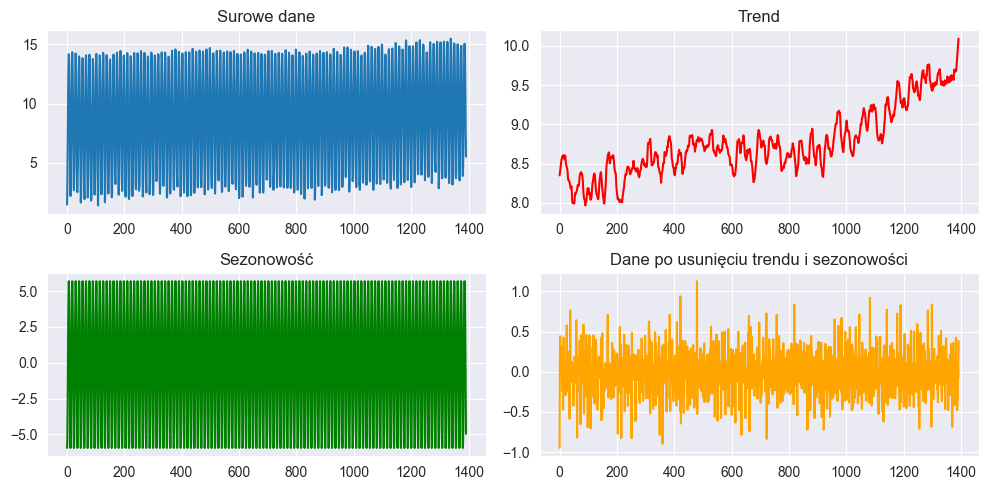

In [36]:
decomposition = seasonal_decompose(nowa_temperature, model='additive', period = 12, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(nowa_temperature, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

(1100.0, 1200.0)

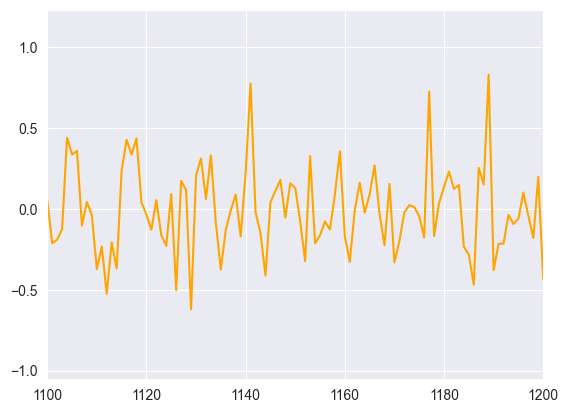

In [138]:
plt.plot(residual,color="orange")
plt.xlim(1100,1200)

In [38]:
mae_residual = np.mean(np.abs(nowa_temperature -residual))
print(f"Mean Absolute Error: {mae_residual}")

Mean Absolute Error: 8.762929178639848


In [39]:
temperature_clean = residual

In [40]:
train_clean, test_clean = train_test_split(temperature_clean, test_size=0.2, shuffle=False)

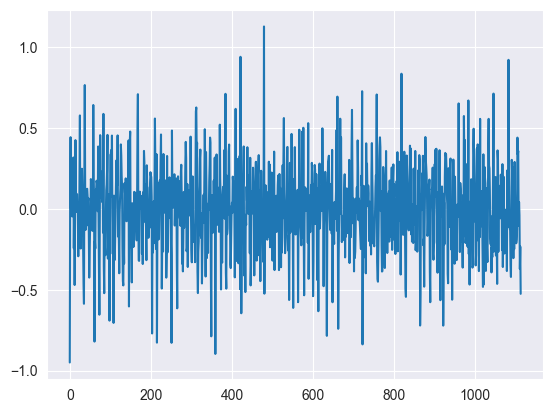

In [41]:
plt.plot(train_clean)

Sprawdzenie stacjonarności dla danych wyczyszczonych

In [42]:
adfuller_test(nowa_temperature)

Statystyka testowa = -0.691, p-value = 0.849 => Non-stationary.


In [43]:
adfuller_test(temperature_clean)

Statystyka testowa = -16.207, p-Value = 0.0 => Stationary. 


ACF i PACF dla wyczyszczonych danych

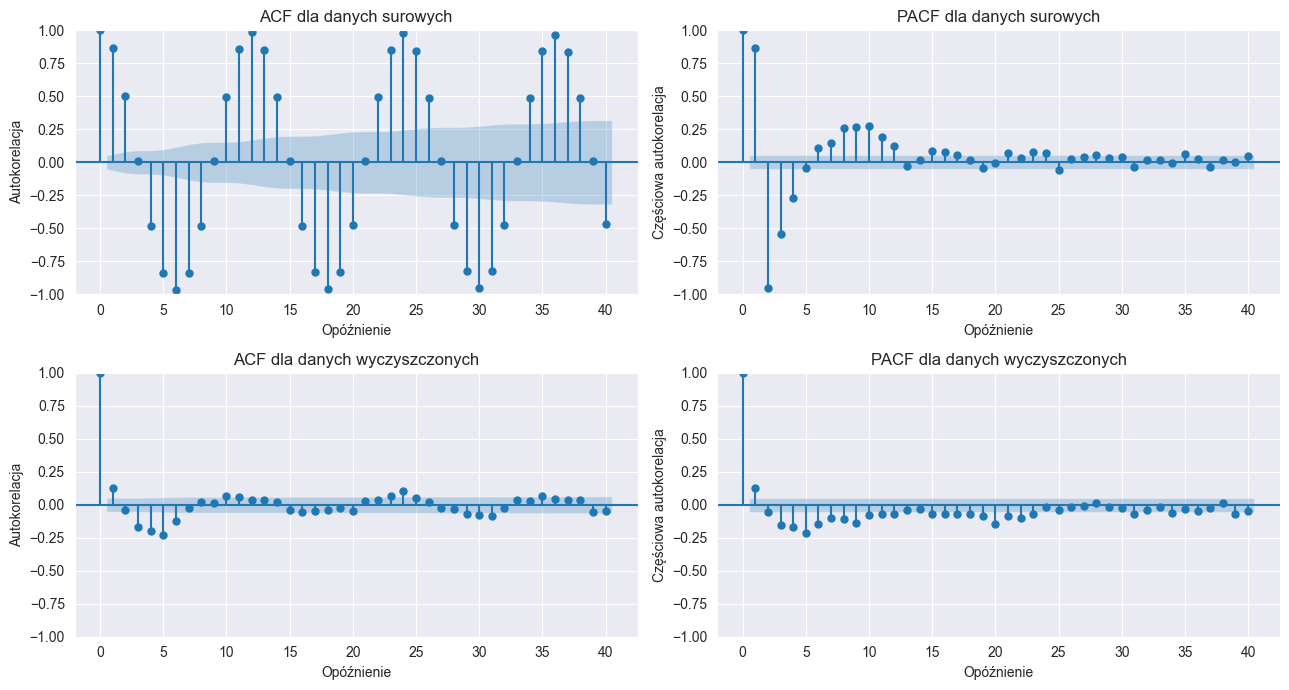

In [44]:
plt.figure(figsize=(13,7))

plt.subplot(223)
plot_acf(temperature_clean, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych wyczyszczonych')

plt.subplot(224)
plot_pacf(temperature_clean, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla danych wyczyszczonych')

plt.subplot(221)
plot_acf(nowa_temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych surowych')

plt.subplot(222)
plot_pacf(nowa_temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla danych surowych')

plt.tight_layout()
plt.show()

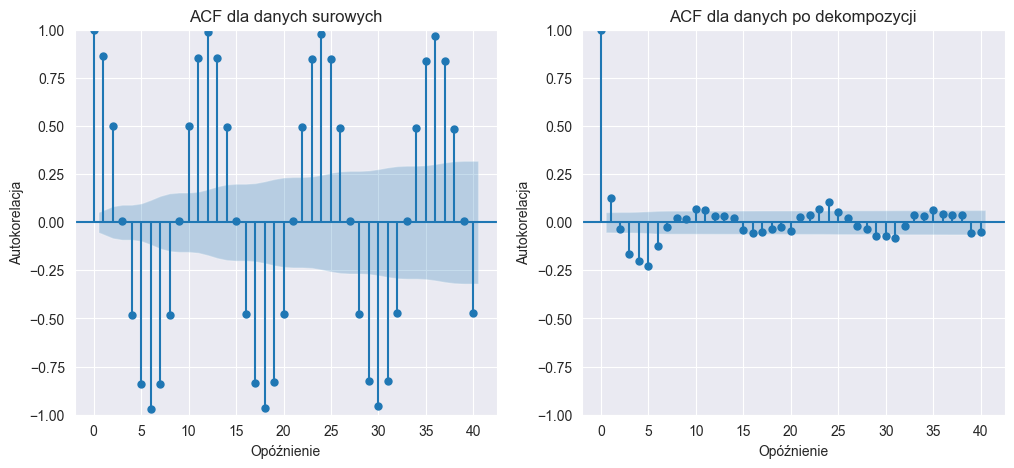

In [45]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plot_acf(nowa_temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych surowych')


plt.subplot(122)
plot_acf(temperature_clean, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych po dekompozycji')

plt.show()

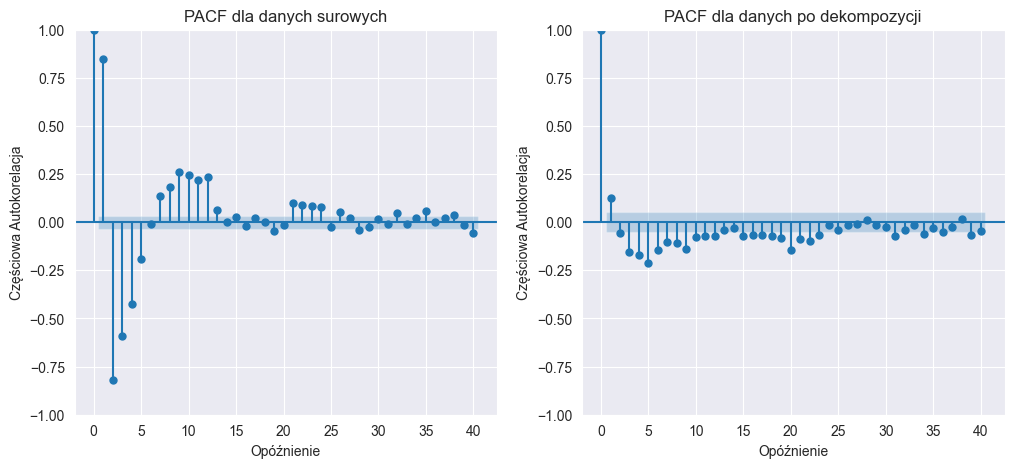

In [46]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plot_pacf(temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa Autokorelacja')
plt.title('PACF dla danych surowych')


plt.subplot(122)
plot_pacf(temperature_clean, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa Autokorelacja')
plt.title('PACF dla danych po dekompozycji')

plt.show()

In [47]:
from scipy.stats import kstest, t, gamma

t_params = t.fit(temperature_clean)
df, loc, scale = t_params

ks_stat, p_value = kstest(temperature_clean, 't', args=(df, loc, scale))

print(f"Statystyka KS: {ks_stat:.4f}")
print(f"P-wartość KS testu: {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value > alpha:
    print("Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z t-rozkladu.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie pasują do t-rozkladu.")

Statystyka KS: 0.0227
P-wartość KS testu: 0.4622
Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z t-rozkladu.


Dopasowanie modelu

In [48]:
df = pd.DataFrame()

ps = []
qs = []
BIC = []
AIC = []
HQIC = []

# Maksymalne wartości p i q
max_p = 5
max_q = 5

# Iteracja po możliwych wartościach p i q
for p in range(0, max_p):
    for q in range(0, max_q):
        
        # Dopasowanie modelu ARMA dla danego p i q
        model = ARIMA(train_clean, order=(p, 0, q))
        model_fit = model.fit()
        
        # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conver

In [49]:
df.sort_values(by='AIC')

,p,q,AIC,BIC,HQIC
19,3,4,-106.277133,-61.143804,-89.212696
21,4,1,-104.972545,-69.868845,-91.700206
16,3,1,-96.389552,-66.300666,-85.013261
22,4,2,-86.747111,-46.628596,-71.578723
24,4,4,-76.314179,-26.166036,-57.353694
18,3,3,-62.130133,-22.011618,-46.961745
11,2,1,-59.766179,-34.692107,-50.285936
23,4,3,-59.074270,-13.940940,-42.009833
17,3,2,-57.062869,-21.959169,-43.790530
8,1,3,-45.145926,-15.057040,-33.769635


In [50]:
df.sort_values(by='BIC')

,p,q,AIC,BIC,HQIC
21,4,1,-104.972545,-69.868845,-91.700206
16,3,1,-96.389552,-66.300666,-85.013261
19,3,4,-106.277133,-61.143804,-89.212696
22,4,2,-86.747111,-46.628596,-71.578723
11,2,1,-59.766179,-34.692107,-50.285936
24,4,4,-76.314179,-26.166036,-57.353694
18,3,3,-62.130133,-22.011618,-46.961745
17,3,2,-57.062869,-21.959169,-43.790530
8,1,3,-45.145926,-15.057040,-33.769635
23,4,3,-59.074270,-13.940940,-42.009833


In [51]:
df.sort_values(by='HQIC')

,p,q,AIC,BIC,HQIC
21,4,1,-104.972545,-69.868845,-91.700206
19,3,4,-106.277133,-61.143804,-89.212696
16,3,1,-96.389552,-66.300666,-85.013261
22,4,2,-86.747111,-46.628596,-71.578723
24,4,4,-76.314179,-26.166036,-57.353694
11,2,1,-59.766179,-34.692107,-50.285936
18,3,3,-62.130133,-22.011618,-46.961745
17,3,2,-57.062869,-21.959169,-43.790530
23,4,3,-59.074270,-13.940940,-42.009833
8,1,3,-45.145926,-15.057040,-33.769635


In [52]:
model1 = pm.auto_arima(train_clean, 
                       d=0,
                       start_p=0,
                       start_q=0,
                       max_d=0,
                       max_p=5, 
                       max_q=5, 
                       max_order=None,
                       trace=True, 
                       seasonal=False, 
                       stepwise = True)

print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=207.838, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=190.067, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=188.559, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=190.503, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=190.371, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=190.554, Time=0.06 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.653 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1113
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 -92.279
Date:                Fri, 31 Jan 2025   AIC                            188.559
Time:                        18:16:48   BIC                            198.588
Sample:                           

Estymacja parametrów

In [54]:
p, q = 4,1

model41 = ARIMA(train_clean, order=(p, 0, q)).fit(method='innovations_mle')

print("Wyniki:")
print(model41.summary())
params41 = model41.params
print(params41)

Wyniki:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1113
Model:                 ARIMA(4, 0, 1)   Log Likelihood                  61.400
Date:                Fri, 31 Jan 2025   AIC                           -108.799
Time:                        18:17:04   BIC                            -73.696
Sample:                             0   HQIC                           -95.527
                               - 1113                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.153e-06   4.73e-05      0.024      0.981   -9.16e-05    9.39e-05
ar.L1          0.8736      0.028     30.674      0.000       0.818       0.929
ar.L2         -0.1545      0.038     -4.033 

In [55]:
import statsmodels.tsa.statespace.sarimax as sss
modell = sss.SARIMAX(train_clean, order=(4, 0, 1)).fit()

# Now test for heteroskedasticity
het_test = modell.test_heteroskedasticity(method='breakvar',alternative='two-sided')
print(het_test)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.42136D-02    |proj g|=  5.74587D-02

At iterate    5    f=  1.67546D-02    |proj g|=  1.59277D-01

At iterate   10    f= -8.53444D-03    |proj g|=  5.20676D-02

At iterate   15    f= -2.81321D-02    |proj g|=  1.03887D-01

At iterate   20    f= -5.26424D-02    |proj g|=  5.44902D-02

At iterate   25    f= -5.48827D-02    |proj g|=  6.48564D-03

At iterate   30    f= -5.51428D-02    |proj g|=  1.10616D-03

At iterate   35    f= -5.51690D-02    |proj g|=  6.98377D-04

At iterate   40    f= -5.51725D-02    |proj g|=  2.68324D-04

At iterate   45    f= -5.51731D-02    |proj g|=  8.53747D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

Przejdziemy teraz do segmentu oceny dopasowania modelu. Zrobimy ją bazując na analizie przedziałów ufności dla autokowariancji ACF i częściowej autokowariancji PACF, porównania linii kwantylowych z trajektorią danych treningowych oraz prognozy przyszłych obserwacji (czyli u nas danych z próbki testowej) oraz skonfrontowania jakości dopasowania dobranego modelu ARMA(4,1) z oryginalnymi danymi, po uwzględnieniu z powrotem sezonowości i trendu.

In [56]:
const = params41[0]
ars = np.r_[1, -np.array(params41[1:p+1])]
mas = np.r_[1, np.array(params41[p+1:p+q+1])]
sigma2 = params41[-1]

M = 5000
n = len(train_clean)
lags = 50
acfs = np.zeros((M,lags+1))
pacfs = np.zeros((M,lags+1))
all_series = np.zeros((M, n))
dopasowany_ar_process = ArmaProcess(ar=ars,ma=mas)
for i in range(M):
    nowe_simulated_data = dopasowany_ar_process.generate_sample(nsample=n, scale = np.sqrt(sigma2))

    all_series[i, :] = nowe_simulated_data
    acfs[i, :] = acf(nowe_simulated_data, nlags=lags, fft=True)
    pacfs[i, :] = pacf(nowe_simulated_data, nlags=lags, method='ywm')

qacf177 = np.zeros(lags + 1)
qacf277 = np.zeros(lags + 1)
qpacf177 = np.zeros(lags + 1)
qpacf277 = np.zeros(lags + 1)

for i in range(lags+1):
    qacf177[i] = np.quantile(acfs[:,i], 0.05)
    qacf277[i] = np.quantile(acfs[:,i], 0.95)
    qpacf177[i] = np.quantile(pacfs[:,i], 0.05)
    qpacf277[i] = np.quantile(pacfs[:,i], 0.95)


qseries01 = np.zeros(n)
qseries02 = np.zeros(n)
qseries03 = np.zeros(n)
qseries04 = np.zeros(n)
qseries05 = np.zeros(n)
qseries06 = np.zeros(n)
qseries07 = np.zeros(n)
qseries08 = np.zeros(n)
qseries09 = np.zeros(n)

for i in range(n):
    qseries01[i] = np.quantile(all_series[:,i], 0.1)
    qseries02[i] = np.quantile(all_series[:,i], 0.2)
    qseries03[i] = np.quantile(all_series[:,i], 0.3)
    qseries04[i] = np.quantile(all_series[:,i], 0.4)
    qseries05[i] = np.quantile(all_series[:,i], 0.5)
    qseries06[i] = np.quantile(all_series[:,i], 0.6)
    qseries07[i] = np.quantile(all_series[:,i], 0.7)
    qseries08[i] = np.quantile(all_series[:,i], 0.8)
    qseries09[i] = np.quantile(all_series[:,i], 0.9)

licznik_0=0
licznik_1=0
licznik_2=0
licznik_3=0
licznik_4=0
licznik_5=0
licznik_6=0
licznik_7=0
licznik_8=0
licznik_9=0
for ns in range(n):
    print(ns)
    probkowy_punkt = train_clean[ns]
    if probkowy_punkt <= qseries01[ns]:
        licznik_0+= 1
    elif qseries01[ns] < probkowy_punkt <= qseries02[ns]:
        licznik_1+= 1
    elif qseries02[ns] < probkowy_punkt <= qseries03[ns]:
        licznik_2 += 1
    elif qseries03[ns] < probkowy_punkt <= qseries04[ns]:
        licznik_3 += 1
    elif qseries04[ns] < probkowy_punkt <= qseries05[ns]:
        licznik_4 += 1
    elif qseries05[ns] < probkowy_punkt <= qseries06[ns]:
        licznik_5 += 1
    elif qseries06[ns] < probkowy_punkt <= qseries07[ns]:
        licznik_6 += 1
    elif qseries07[ns] < probkowy_punkt <= qseries08[ns]:
        licznik_7 += 1
    elif qseries08[ns] < probkowy_punkt <= qseries09[ns]:
        licznik_8 += 1
    elif qseries09[ns] < probkowy_punkt:
        licznik_9 += 1
liczniki=[100*licznik_0/n,100*licznik_1/n,100*licznik_2/n,100*licznik_3/n,100*licznik_4/n,100*licznik_5/n,100*licznik_6/n,100*licznik_7/n,100*licznik_8/n,100*licznik_9/n]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
M = 5000
n = len(train_clean)
lags = 50
acfs = np.zeros((M,lags+1))
pacfs = np.zeros((M,lags+1))
all_series = np.zeros((M, n))
dopasowany_ar_process = ArmaProcess(ar=ars,ma=mas)
for i in range(M):
    nowe_simulated_data = dopasowany_ar_process.generate_sample(nsample=n, scale = np.sqrt(sigma2))

    all_series[i, :] = nowe_simulated_data
    acfs[i, :] = acf(nowe_simulated_data, nlags=lags, fft=True)
    pacfs[i, :] = pacf(nowe_simulated_data, nlags=lags, method='ywm')

qacf177 = np.zeros(lags + 1)
qacf277 = np.zeros(lags + 1)
qpacf177 = np.zeros(lags + 1)
qpacf277 = np.zeros(lags + 1)

for i in range(lags+1):
    qacf177[i] = np.quantile(acfs[:,i], 0.05)
    qacf277[i] = np.quantile(acfs[:,i], 0.95)
    qpacf177[i] = np.quantile(pacfs[:,i], 0.05)
    qpacf277[i] = np.quantile(pacfs[:,i], 0.95)

Na początku na tapet weźmiemy funkcje ACF i PACF dla naszych danych po dekompozycji i porównamy je z granicami przedziałów ufności skonstruowanych dla 90% (5% od dołu i 95% od góry). Procedura wyznaczenia ich będzie polegała na wysymulowaniu 5000 próbek Monte Carlo, o długości takiej samej jak analizowane przez nas ostatecznie dane, metodą *generate_sample* z odpowiednio wyznaczonymi wcześniej dzięki pakietowi statsmodels.tsa.arima.model.ARIMA parametrami, a następnie analizie funkcji ACF i PACF wszystkich trajektorii w odpowiadających sobie punktach. W ten sposób dla uzyskanych wartości sporządzamy dla każdego opóźnienia rzędu od 0 do 50 kwantyle 5% i 95%, a następnie wizualizujemy je razem z empirycznymi wartościami tych funkcji dla naszych danych po dekompozycji.


bierzemy te wartosci parametrow z modelu wyestymowanego i symulacyjnie generujemy 5000 probek szeregu czasowego ARMA, nastepnie dla kazdej probki wyznaczamy wartosci acf i pacf dla lagu az do 50, aby pozniej wyznaczamy przedzial ufnosci 90%, poprzez kwantyl 5% i 95% z danej w kazdym punkcie naszych wygenerowanych modeli (kwantyle na podstawie wszystkich wartosci)

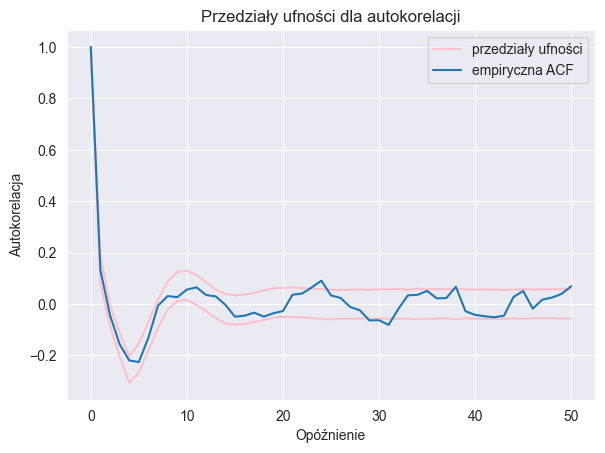

In [353]:
hs = np.linspace(0,lags,lags+1)
plt.figure().set_figwidth(15)
plt.subplot(1,2,1)
plt.plot(qacf177,color="pink",label="przedziały ufności")
plt.plot(qacf277,color="pink")
plt.plot(hs,acf(train_clean, nlags=lags, fft=True),label="empiryczna ACF")
plt.title('Przedziały ufności dla autokorelacji')
plt.xlabel("Opóźnienie")
plt.ylabel("Autokorelacja")
plt.legend()
plt.legend()

przedzialy ufnosci acf 90% -> dane kreca sie wokol, widac gorke kolo lagu 10, do którego dopasowuje sie trajektoria autokowariancji wyznaczona metoda acf, chwile po 12 lagu, czyli naszym jednym roku, dane sie stabilizuja wokol 0, nieznacznie niektore dane wychodza poza przedzial ale generalnie przedzial ufnosci dopasowuje sie do trajekotrii wyznaczonej dla naszych danych treningowych po dekopozycji, nie ma wyraznych skokow w pewnych odstepach, szczegolnie po 20 lagu co oznacza ze faktycznie nie dochodzi tu do sezonowosci 

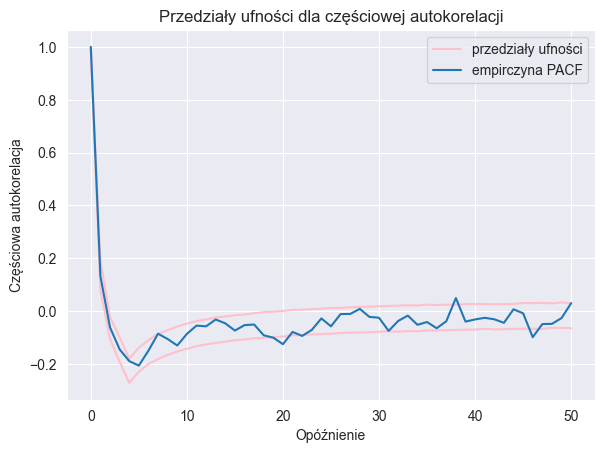

In [354]:
plt.figure().set_figwidth(15)
plt.subplot(1,2,1)
plt.plot(qpacf177,color="pink",label="przedziały ufności")
plt.plot(qpacf277,color="pink")
plt.plot(hs,pacf(train_clean, nlags=lags, method='ywm'),label="empirczyna PACF")
plt.title('Przedziały ufności dla częściowej autokorelacji')
plt.xlabel("Opóźnienie")
plt.ylabel("Częściowa autokorelacja")
plt.legend()
plt.legend()
plt.show()


przy pacf mamy podobna sytuacje jak przy okazji acf, przedzialy ufnosci dobrze dopaosowane do trajektorii dla naszych danych oczyszczonych, 

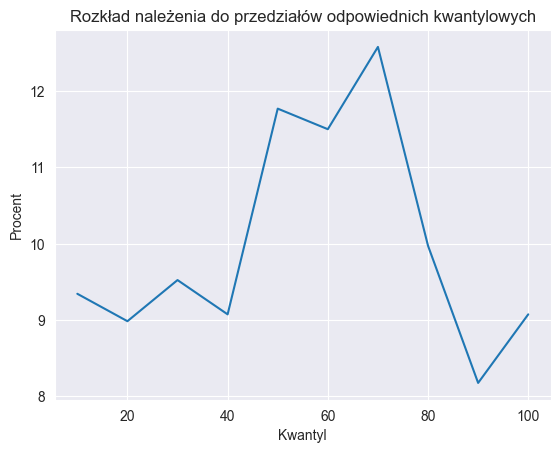

In [372]:
quant_s = np.linspace(10,100,10)
plt.plot(quant_s,liczniki)
plt.title("Rozkład należenia do przedziałów odpowiednich kwantylowych")
plt.ylabel("Procent")
plt.xlabel("Kwantyl")
plt.show()

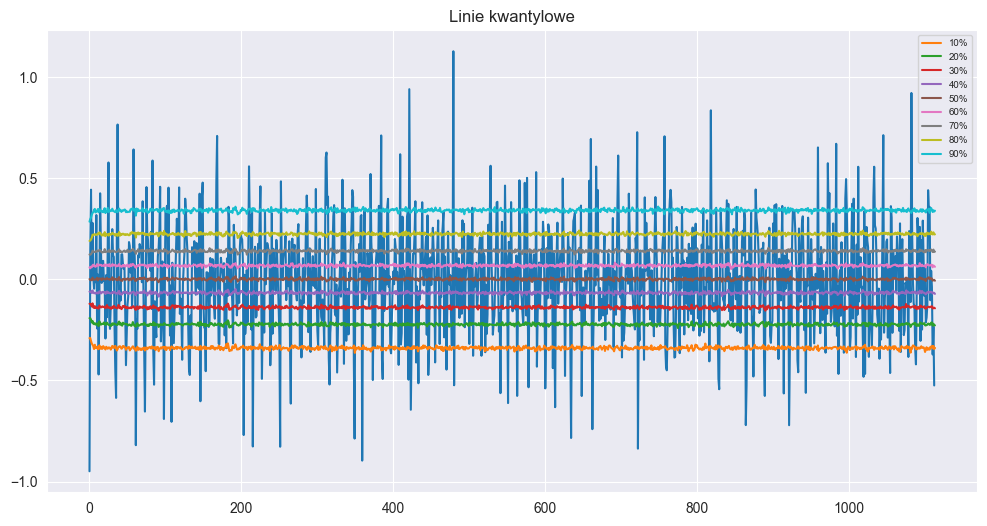

In [369]:
ns = np.linspace(0,len(train_clean),len(train_clean))
plt.figure(figsize=((12,6)))
plt.plot(train_clean)
plt.plot(ns, qseries01, label="10%")
plt.plot(ns, qseries02, label="20%")
plt.plot(ns, qseries03, label="30%")
plt.plot(ns, qseries04, label="40%")
plt.plot(ns, qseries05, label="50%")
plt.plot(ns, qseries06, label="60%")
plt.plot(ns, qseries07, label="70%")
plt.plot(ns, qseries08, label="80%")
plt.plot(ns, qseries09, label="90%")
plt.title("Linie kwantylowe")
plt.legend(prop={'size': 7})
plt.show()

In [206]:
train_special = list(train_clean)
train_special.append(test_clean[0])

1114


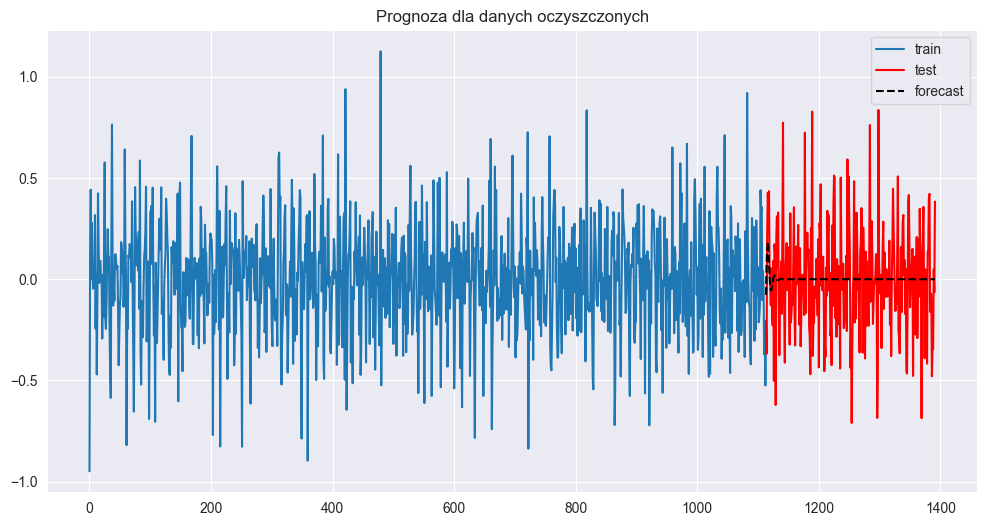

In [376]:
forecast1 = model41.forecast(steps=len(test_clean))
print(len(train_special))
test_ns = np.linspace(len(train_clean),len(nowa_temperature)-1,len(test_clean))
plt.figure(figsize=(12,6))
plt.plot(train_special,label="train")
plt.plot(test_ns,test_clean,color="red",label="test")
plt.plot(test_ns,forecast1, label='forecast', linestyle='--',color="black")
plt.title("Prognoza dla danych oczyszczonych")
plt.legend()

In [74]:
fitted_values = list(model41.predict())
fitted_values.extend(list(forecast1))
ostateczny = fitted_values + trend + seasonal

In [209]:
treningowe,testowe = list(nowa_temperature)[:1113],list(nowa_temperature)[1113:]

In [186]:
tren_ns = np.linspace(0,len(treningowe),len(treningowe)+1)
print(tren_ns)
test_ns = np.linspace(len(train_clean),len(nowa_temperature)-1,len(test_clean))

[0.000e+00 1.000e+00 2.000e+00 ... 1.111e+03 1.112e+03 1.113e+03]


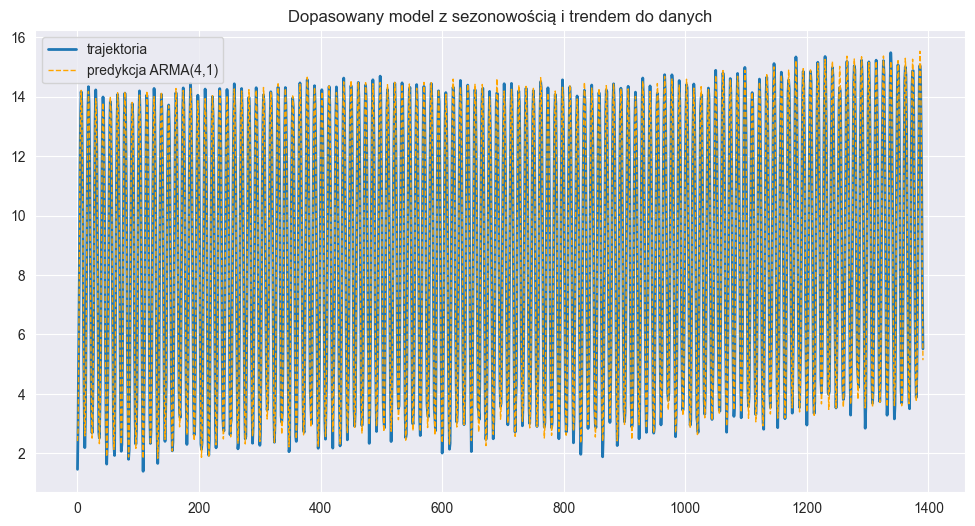

In [398]:
plt.figure(figsize=(12,6))
plt.plot(nowa_temperature,linewidth=2,label="trajektoria")
plt.plot(ostateczny,color="orange",linestyle="--",linewidth=1,label="predykcja ARMA(4,1)")
plt.title("Dopasowany model z sezonowością i trendem do danych")
plt.legend(prop={'size': 5})
plt.legend()

In [187]:
treningowe_specjalny = treningowe
treningowe_specjalny.append(testowe[0])

1113
[0.000e+00 1.000e+00 2.000e+00 ... 1.111e+03 1.112e+03 1.113e+03]


Text(0.5, 1.0, 'Prognoza dla samych wartości testowych')

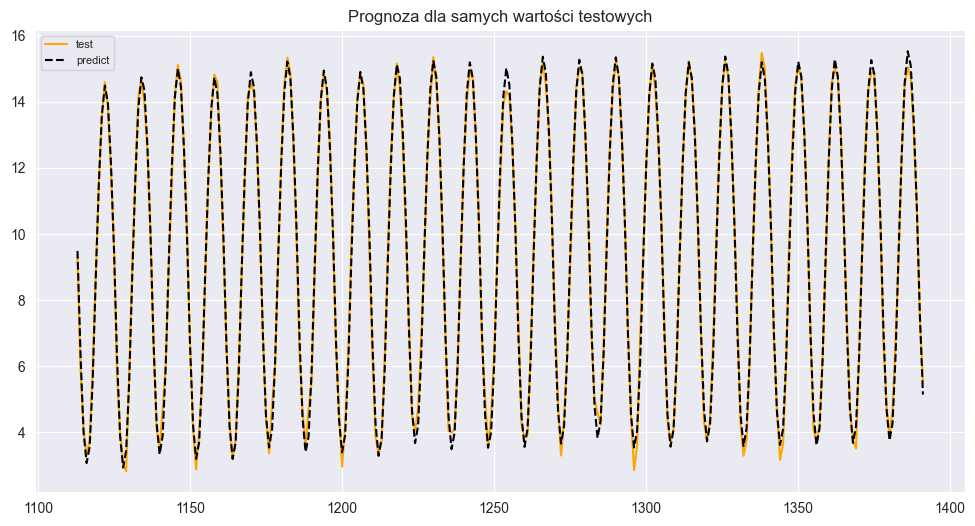

In [408]:
print(len(treningowe))
print(tren_ns)
plt.figure(figsize=(12,6))
plt.plot(test_ns,testowe,label="test",color="orange")
plt.plot(test_ns,list(ostateczny)[len(train_clean):],linestyle="--",color="black",label="predict")
plt.legend(prop={'size': 8})
plt.title("Prognoza dla samych wartości testowych")

In [256]:
from scipy.stats import kstest, t, gamma, norm

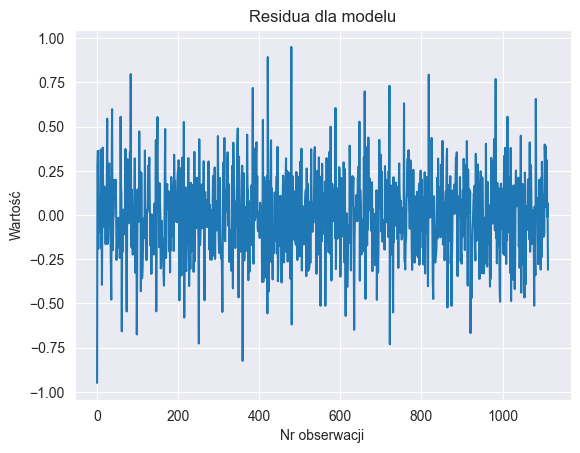

In [409]:
residua =model41.resid
# Plot the residuals
plt.plot(residua)
plt.title('Residua dla modelu')
plt.xlabel('Nr obserwacji')
plt.ylabel('Wartość')


plt.show()

In [257]:
# model41.plot_diagnostics(figsize=(10, 8))
# plt.tight_layout()
# plt.show()

### NORMALNOSC

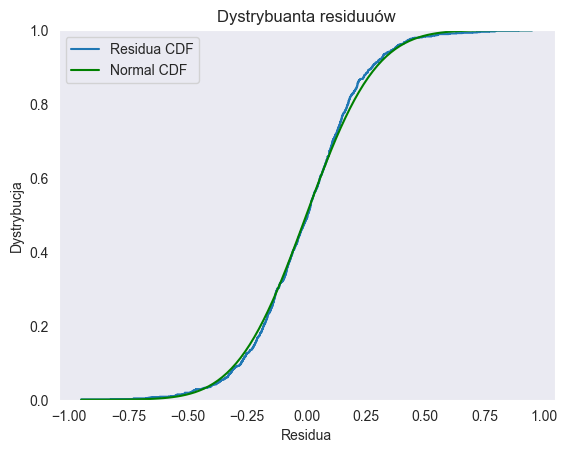

In [413]:
t_params = t.fit(residua)
df_fit, loc_fit, scale_fit = t_params
x = np.linspace(min(residua), max(residua), 100)
t_cdf_vals = t.cdf(x, df=df_fit, loc=loc_fit, scale=scale_fit)
mu_norm, sigma_norm = norm.fit(residua)
normal_cdf_vals = norm.cdf(x, loc=mu_norm, scale=sigma_norm)
t_pdf = t.pdf(x, df=df_fit, loc=loc_fit, scale=scale_fit)
norm_pdf = norm.pdf(x, loc=mu_norm, scale=sigma_norm)
# Plot CDF
sns.ecdfplot(residua,label="Residua CDF")
# plt.plot(x, t_cdf_vals, label=f"t Student's CDF (df={df_fit:.2f})", color="red")
plt.plot(x, normal_cdf_vals, label="Normal CDF", color="green")
plt.title("Dystrybuanta residuuów")
plt.xlabel("Residua")
plt.ylabel("Dystrybucja")
plt.grid()
plt.legend()
plt.show()

Dopasowane parametry t-rozkladu: df=8.57, loc=-0.00, scale=0.20


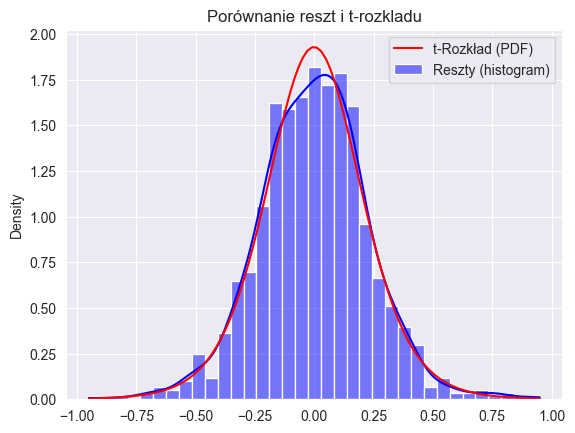

In [414]:
t_params = t.fit(residua)
df_fit, loc_fit, scale_fit = t_params

print(f"Dopasowane parametry t-rozkladu: df={df_fit:.2f}, loc={loc_fit:.2f}, scale={scale_fit:.2f}")

import seaborn as sns

sns.histplot(residua, kde=True, stat="density", label="Reszty (histogram)", color="blue")
x = np.linspace(min(residua), max(residua), 100)
plt.plot(x, t.pdf(x, df_fit, loc_fit, scale_fit), label="t-Rozkład (PDF)", color="red")
# plt.plot(x, norm_pdf, label="Fitted Normal PDF", color="green")
plt.legend()
plt.title("Porównanie reszt i t-rozkladu")
plt.show()

8.56544844099998


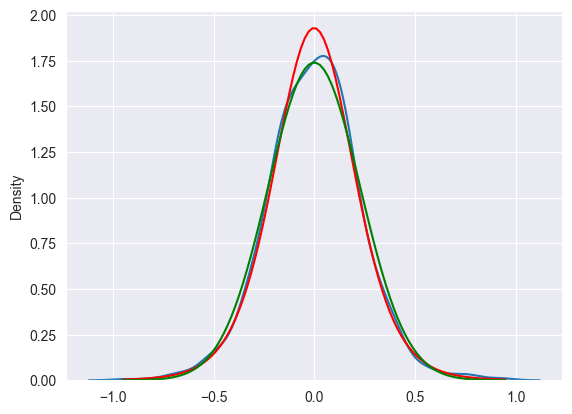

In [344]:
sns.kdeplot(residua)
plt.plot(x, t_pdf, label=f"Fitted Student's t PDF (df={df_fit:.2f})", color="red")
plt.plot(x, norm_pdf, label="Fitted Normal PDF", color="green")

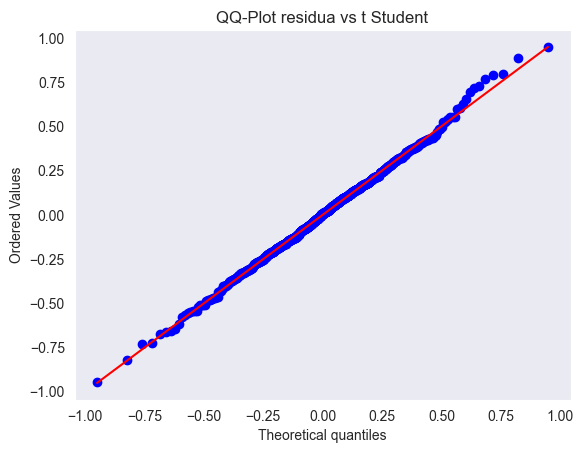

In [415]:
import scipy
scipy.stats.probplot(residua, dist="t", sparams=(df_fit, loc_fit, scale_fit), plot=plt)
plt.title("QQ-Plot residua vs t Student")
plt.grid()
plt.show()

((array([-0.74108197, -0.68078126, -0.64716535, ...,  0.64609089,
          0.67970681,  0.74000752]),
  array([-0.94941956, -0.82476239, -0.73096683, ...,  0.79708852,
          0.89296878,  0.95055363])),
 (0.9978597170855712, -1.1498167638754851e-06, 0.9953353532961984))

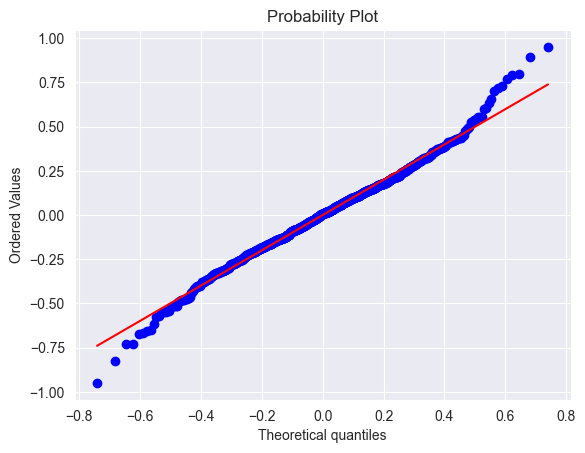

In [253]:
scipy.stats.probplot(residua, dist="norm", sparams=(mu_norm,sigma_norm), plot=plt)

In [254]:
from scipy.stats import shapiro

stat, p_value = shapiro(residua)

# Wyniki testu
print(f"Statystyka Shapiro-Wilka: {stat}")
print(f"P-wartość: {p_value}")

# Wniosek
alpha = 0.05  # Poziom istotności
if p_value > alpha:
    print("Nie można odrzucić hipotezy zerowej: Dane mają rozkład normalny.")
else:
    print("Odrzucamy hipotezę zerową: Dane nie mają rozkładu normalnego.")

Statystyka Shapiro-Wilka: 0.9915878176689148
P-wartość: 5.588492058450356e-06
Odrzucamy hipotezę zerową: Dane nie mają rozkładu normalnego.


In [255]:
ks_stat, p_value = kstest(residua, 't', args=(df_fit, loc_fit, scale_fit))

print(f"Statystyka KS: {ks_stat:.4f}")
print(f"P-wartość KS testu: {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value > alpha:
    print("Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z t-rozkladu.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie pasują do t-rozkladu.")

Statystyka KS: 0.0225
P-wartość KS testu: 0.6197
Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z t-rozkladu.


In [244]:
gamma_params = gamma.fit(residua)
shape, loc, scale = gamma_params

# Test Kolmogorova-Smirnova (KS test) dla gamma-rozkladu
ks_stat, p_value = kstest(residua, 'gamma', args=(shape, loc, scale))

print(f"Dopasowane parametry gamma-rozkladu: shape={shape:.4f}, loc={loc:.4f}, scale={scale:.4f}")
print(f"Statystyka KS: {ks_stat:.4f}")
print(f"P-wartość KS testu: {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value > alpha:
    print("Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z gamma-rozkladu.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie pasują do gamma-rozkladu.")

Dopasowane parametry gamma-rozkladu: shape=1764.4731, loc=-9.6344, scale=0.0055
Statystyka KS: 0.0312
P-wartość KS testu: 0.2228
Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z gamma-rozkladu.


In [245]:
from scipy.stats import weibull_min
weibull_params = weibull_min.fit(residua)
shape, loc, scale = weibull_params

# Test Kolmogorova-Smirnova (KS test) dla Weibull-rozkładu
ks_stat, p_value = kstest(residua, 'weibull_min', args=(shape, loc, scale))

print(f"Dopasowane parametry Weibull-rozkładu: shape={shape:.4f}, loc={loc:.4f}, scale={scale:.4f}")
print(f"Statystyka KS: {ks_stat:.4f}")
print(f"P-wartość KS testu: {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value > alpha:
    print("Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z Weibull-rozkładu.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie pasują do Weibull-rozkładu.")

Dopasowane parametry Weibull-rozkładu: shape=3.7886, loc=-0.7994, scale=0.8825
Statystyka KS: 0.0417
P-wartość KS testu: 0.0401
Odrzucamy hipotezę zerową - reszty nie pasują do Weibull-rozkładu.


In [246]:
from scipy.stats import norm, kstest

# Dopasowanie rozkładu normalnego do reszt
normal_params = norm.fit(residua)
loc, scale = normal_params

# Test Kolmogorova-Smirnova (KS test) dla rozkładu normalnego
ks_stat, p_value = kstest(residua, 'norm', args=(loc, scale))

print(f"Dopasowane parametry rozkładu normalnego: loc={loc:.4f}, scale={scale:.4f}")
print(f"Statystyka KS: {ks_stat:.4f}")
print(f"P-wartość KS testu: {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value > alpha:
    print("Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z rozkładu normalnego.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie pasują do rozkładu normalnego.")

Dopasowane parametry rozkładu normalnego: loc=-0.0005, scale=0.2294
Statystyka KS: 0.0315
P-wartość KS testu: 0.2147
Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z rozkładu normalnego.


### NIEZALEZNOSC

In [247]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(residua, lags=[int(np.sqrt(len(nowa_temperature)))], return_df=True)

,lb_stat,lb_pvalue
37,49.373687,0.08392


In [279]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residua, lags=[int(np.sqrt(len(nowa_temperature)))], return_df=True)
print(lb_test)

if lb_test["lb_pvalue"].values[0] < 0.05:
    print("Residuals are autocorrelated → Model is misspecified.")
else:
    print("Residuals are white noise → Model is appropriate.")

      lb_stat  lb_pvalue
37  49.373687    0.08392
Residuals are white noise → Model is appropriate.


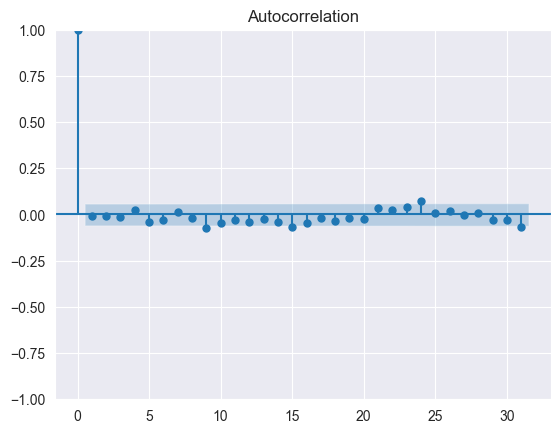

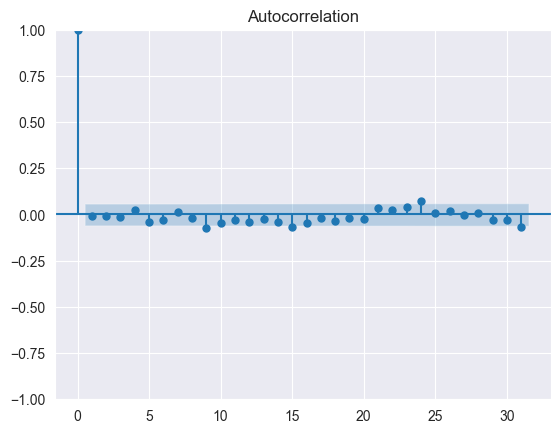

In [261]:
plot_acf(residua)

### SREDNIA=0

In [ ]:
from scipy.stats import ttest_1samp
stat, p = ttest_1samp(residua, popmean=0)
print(stat,p)

-0.07809733919000025 0.9377646738311822


 test statystyczny z H0: mu=0 (np. t-test),

In [274]:
print(np.mean(residua))

-0.0005372265302695274


srednia rzedu 10*-4 czyli calkiem mala

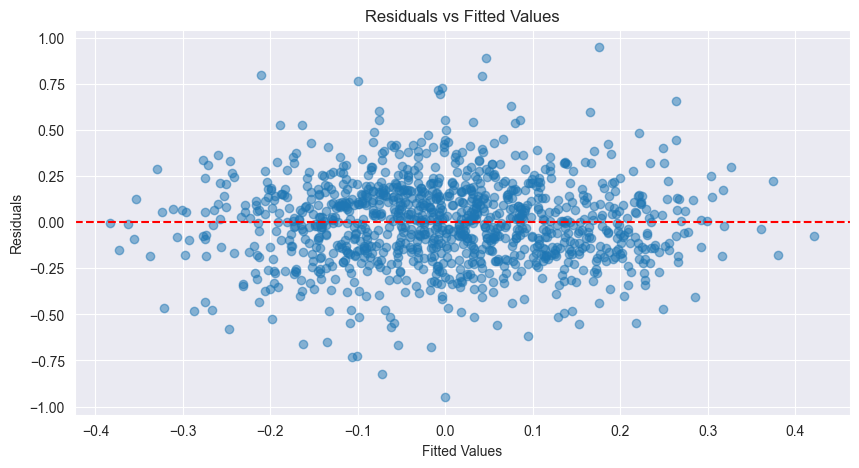

In [301]:
plt.figure(figsize=(10, 5))
plt.scatter(model41.fittedvalues, residua, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

### WARIANCJA

In [300]:
from statsmodels.stats.diagnostic import het_arch

p_value = het_arch(residua)
print(p_value)

(36.85215336888216, 6.002465735398444e-05, 3.774575131017737, 5.135896226597392e-05)


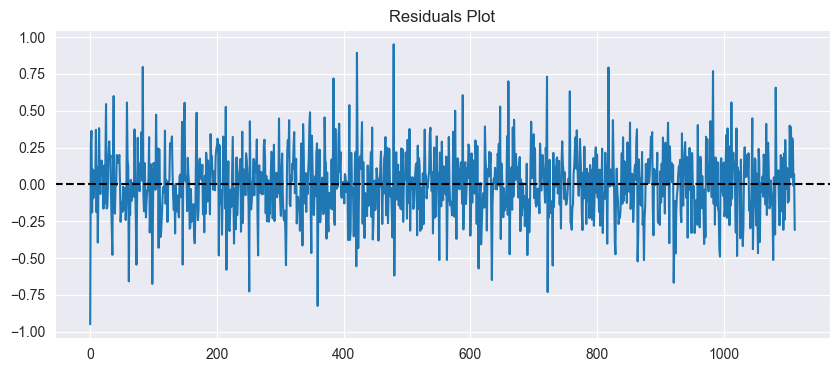

In [276]:
plt.figure(figsize=(10, 4))
plt.plot(residua)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals Plot")
plt.show()

In [316]:
from statsmodels.stats.diagnostic import het_breuschpagan
import numpy as np
import statsmodels.api as sm

# Get residuals and fitted values
radio = model41.fittedvalues
exog = sm.add_constant(radio)  
print(exog)
# exog = model41.fittedvalues.model.exog
# print(exog)
# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residua, exog)

# Extract p-value
p_value = bp_test[1]

print(f"Breusch-Pagan test p-value: {p_value}")

if p_value < 0.05:
    print("Heteroskedasticity detected (residual variance is not constant).")
else:
    print("No significant heteroskedasticity detected (residual variance is constant).")


[[ 1.00000000e+00  1.15323682e-06]
 [ 1.00000000e+00 -1.28603078e-01]
 [ 1.00000000e+00  7.96519080e-02]
 ...
 [ 1.00000000e+00 -3.62249304e-01]
 [ 1.00000000e+00 -3.00977153e-01]
 [ 1.00000000e+00 -2.15408253e-01]]
Breusch-Pagan test p-value: 0.31507926042231693
No significant heteroskedasticity detected (residual variance is constant).


In [325]:
scipy.stats.kurtosis(residua,fisher=False)

4.080562073147987

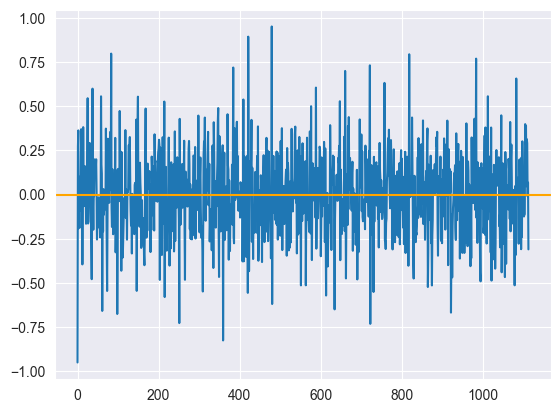

In [416]:
srednia = scipy.stats.trim_mean(residua, 0.1)
plt.plot(residua)
plt.axhline(srednia,color="orange")

In [417]:
from scipy.stats import levene

group1 = residua[residua <= srednia]  # Below or equal to median
group2 = residua[residua > srednia]   # Above median

# Perform the Modified Levene Test
stat, p_value = levene(group1, group2, center='median')

# Display results
print(f"Levene Statistic: {stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: Variances are not equal (heteroscedasticity detected).")
else:
    print("Fail to reject the null hypothesis: Residuals have equal variance (homoscedasticity).")

Levene Statistic: 0.0045
P-Value: 0.9463
Fail to reject the null hypothesis: Residuals have equal variance (homoscedasticity).


In [342]:
mid = len(residua) // 2
group1, group2 = residua[:mid], residua[mid:]

# Perform Modified Levene Test (centered around median)
lev_stat, lev_pval = levene(group1, group2, center='median')

print(f"Modified Levene Test Statistic: {lev_stat:.4f}")
print(f"P-value: {lev_pval:.4f}")

# Interpretation
if lev_pval > 0.05:
    print("Fail to reject H0: No significant heteroskedasticity detected.")
else:
    print("Reject H0: Heteroskedasticity detected.")

Modified Levene Test Statistic: 0.2071
P-value: 0.6491
Fail to reject H0: No significant heteroskedasticity detected.


In [ ]:
from scipy.stats import bartlett

stat, p_value = bartlett(group1, group2)
print(f"Bartlett's test p-value: {p_value:.4f}")

Bartlett's test p-value: 0.7390


In [ ]:
jarque_bera_test = statsmodels.stats.stattools.jarque_bera(residua, axis=0)
print(jarque_bera_test)

(54.68827387244957, 1.3322699006450105e-12, 0.05396196894464985, 4.080562073147987)


In [ ]:
from statsmodels.stats.diagnostic import het_arch
# Perform ARCH test (default lag=1)
arch_test = het_arch(residua)

# Extract results
LM_stat = arch_test[0]  # Lagrange Multiplier statistic
p_value = arch_test[1]  # p-value
f_stat = arch_test[2]   # F-statistic
f_p_value = arch_test[3]  # F-test p-value

# Print results
print(f"ARCH Test Results:")
print(f"Lagrange Multiplier Statistic: {LM_stat:.4f}")
print(f"LM Test p-value: {p_value:.4f}")
print(f"F-statistic: {f_stat:.4f}")
print(f"F-test p-value: {f_p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: Heteroscedasticity detected (ARCH effects present).")
else:
    print("Fail to reject the null hypothesis: No significant ARCH effects (homoscedastic residuals).")

ARCH Test Results:
Lagrange Multiplier Statistic: 36.8522
LM Test p-value: 0.0001
F-statistic: 3.7746
F-test p-value: 0.0001
Reject the null hypothesis: Heteroscedasticity detected (ARCH effects present).


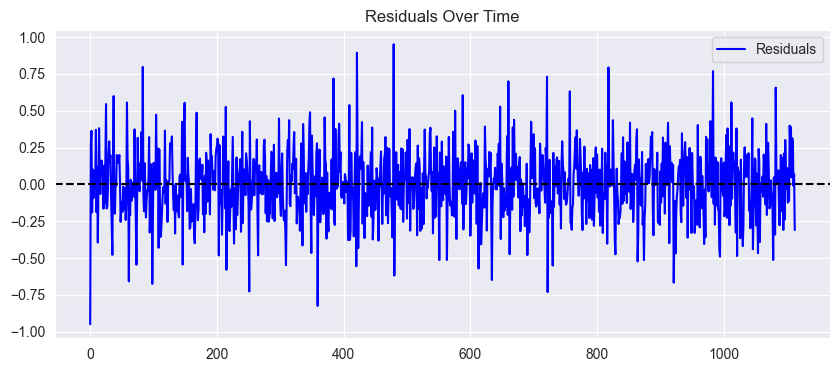

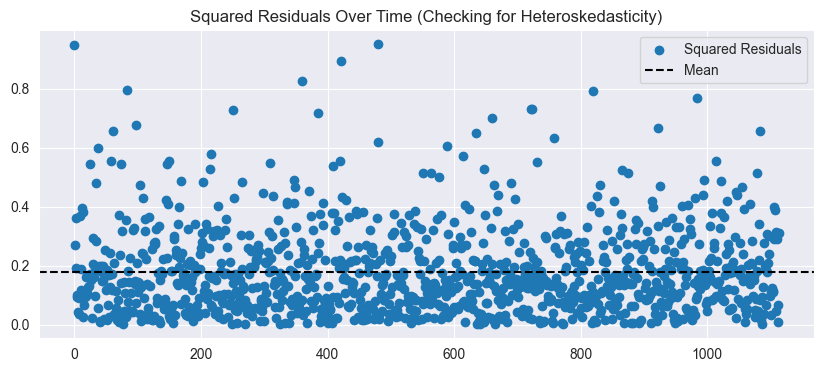

In [270]:
plt.figure(figsize=(10, 4))
plt.plot(residua, label="Residuals", color="blue")
plt.axhline(y=0, color="black", linestyle="--")
plt.title("Residuals Over Time")
plt.legend()
plt.show()

# Plot squared residuals to check for volatility clustering
plt.figure(figsize=(10, 4))
plt.scatter(ns,abs(residua), label="Squared Residuals")
plt.axhline(y=np.mean(abs(residua)), color="black", linestyle="--", label="Mean")
plt.title("Squared Residuals Over Time (Checking for Heteroskedasticity)")
plt.legend()
plt.show()